In [1]:
import pandas as pd
import numpy as np

#Learning Data with 11 features (10 IVs and 1 DV) on LMS 
#In the course, pass or fail only depends on Final_exam_grade
#Other features are only references to instructors
df = pd.read_excel('EDUCAUSE_Data.xls', sep=",")
df.info()
print(df.isnull().sum().sum())
print(len(df['USERID']))
#2006 learners

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 12 columns):
USERID                       2006 non-null object
Avg_quiz_score               2006 non-null float64
Avg_discussion_posts         2006 non-null float64
Participation_score          2006 non-null float64
Course_visit_time            2005 non-null float64
Avg_homework_score           2005 non-null float64
Homework_complete_rate       2005 non-null float64
Avg_homework_submit_times    2005 non-null float64
Mid-term_homework_score      2006 non-null int64
Mid-term_exam_score          2006 non-null int64
Course_visits                2006 non-null int64
Final_exam_grade             2006 non-null int64
dtypes: float64(7), int64(4), object(1)
memory usage: 188.2+ KB
4
2006


In [2]:
#min-max normalization on the 10 IV features
df_scaling = df.dropna(axis=0)
print(df_scaling.isnull().sum().sum())
print(len(df_scaling['USERID']))
#1 attrition

0
2005


In [3]:
from sklearn.preprocessing import MinMaxScaler
df_scaling = df_scaling.set_index('USERID')
scaler = MinMaxScaler()    # Scaling to 0~1
df_scaling.iloc[:, :10] = scaler.fit_transform(df_scaling.iloc[:, :10])    #axis = 0; scaleing on each column

C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [4]:
#Transform Final_exam_grade to pass(1)/fail(0) status
def pass_or_fail(x):
    if x >= 60:
        return 1
    else:
        return 0

df_scaling['Pass/Faill'] = df_scaling['Final_exam_grade'].apply(pass_or_fail)

In [6]:
#IVs
features = df_scaling[df_scaling.columns[~df_scaling.columns.isin(['Final_exam_grade', 'Pass/Faill'])]]
#DV
target = df_scaling['Pass/Faill']

In [7]:
#Train a random forest model to predict learners' pass/fail status
#which will be used in the algorithm aversion experiment
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
kf = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)

#Use training dataset for cross-validation
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=1)
cross_val_score(RF, features_train, target_train, cv = kf, scoring = "accuracy", n_jobs=-1)

#Using a random forest model for the prediction looks pretty good 

array([0.98671096, 0.99003322, 0.97009967, 0.98671096, 0.98006645,
       0.98327759])

In [9]:
#Train the model
RF.fit(features_train, target_train)

C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
#Evaluate the model using test dataset
RF.score(features_test, target_test)

#the model with an accuracy rate of 99.5%

0.9950248756218906

In [14]:
#Feature importance of the model
print(RF.feature_importances_)
print(df_scaling.columns[:10])

[0.08189045 0.11692449 0.09189417 0.01609286 0.02136691 0.01189993
 0.06500661 0.47462488 0.07941925 0.04088045]
Index(['Avg_quiz_score', 'Avg_discussion_posts', 'Participation_score',
       'Course_visit_time', 'Avg_homework_score', 'Homework_complete_rate',
       'Avg_homework_submit_times', 'Mid-term_homework_score',
       'Mid-term_exam_score', 'Course_visits'],
      dtype='object')


In [23]:
np.argsort(RF.feature_importances_).tolist()

[5, 3, 4, 9, 6, 8, 0, 2, 1, 7]

<BarContainer object of 10 artists>

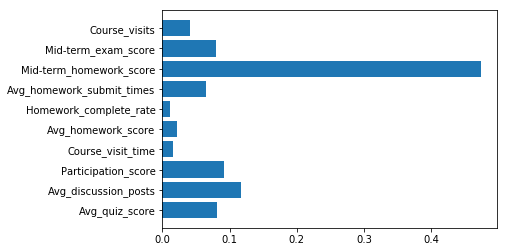

In [13]:
plt.barh(df_scaling.columns[:10], RF.feature_importances_)

In [20]:
feature_importance_in_order = np.argsort(RF.feature_importances_).tolist()

name_in_order = []
for i in feature_importance_in_order: 
    name_in_order.append(list(df_scaling.columns[:10])[i])
score_in_order = []
for i in feature_importance_in_order: 
    score_in_order.append(RF.feature_importances_[i])

<BarContainer object of 10 artists>

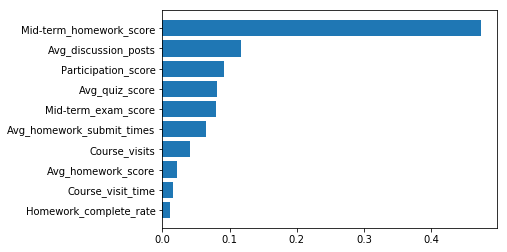

In [21]:
#Interpretable/explanable chart
plt.barh(name_in_order, score_in_order)

#This interpretable/explanable chart will be presented to participants in the algorithm aversion experiment